In [1]:
using LinearAlgebra

In [2]:
function lagrange_basis(geom="triangular", order=1)
    if (geom == "triangular" && order == 1)
        # basis functions
        ϕ₁(x, y) = 1 - x - y
        ϕ₂(x, y) = y
        ϕ₃(x, y) = x
        ϕ = (ϕ₁, ϕ₂, ϕ₃)
        
        # gradients
        ∇ϕ₁(x, y) = [-1, -1]
        ∇ϕ₂(x, y) = [1, 0]
        ∇ϕ₃(x, y) = [0, 1]
        ∇ϕ = (∇ϕ₁, ∇ϕ₂, ∇ϕ₃)
        
        # quadrature nodes and weights
        x₁ = [0.5, 0]
        x₂ = [0, 0.5]
        x₃ = [0.5, 0.5]        
        nodes = (x₁, x₂, x₃)
        weights = (1/6, 1/6, 1/6)
    end
    
    return ϕ, ∇ϕ, nodes, weights
end

lagrange_basis (generic function with 3 methods)

In [3]:
function quadrature(fun, nodes, weights)
    rv = 0
    for (i, n) in enumerate(nodes)
        rv += fun(n[1], n[2]) * weights[i]
    end
    return rv
end

quadrature (generic function with 1 method)

In [4]:
function element_affine_map(x, y; v₁=[1 1], v₂=[1 0], v₃=[0 1])
    return (v₂ - v₁) * x + (v₃ - v₁) * y + v₁
end

element_affine_map (generic function with 1 method)

In [5]:
function get_local_matrix(∇ϕ)
    n = length(∇ϕ)
    rv = zeros(n, n)
    
    _, _, nodes, weights = lagrange_basis()
    for i ∈ 1:n
        for j ∈ 1:n
            phi(x, y) = dot(∇ϕ[i](x, y), ∇ϕ[j](x, y))
            rv[i, j] = quadrature(phi, nodes, weights)
        end
    end
    return rv
end

get_local_matrix (generic function with 1 method)

In [6]:
function solve_poisson_dirichlet(fun, p, simplices, border)
    
    ϕ, ∇ϕ, nodes, weights = lagrange_basis()
    
    for i ∈ 1:size(simplices, 2)
        simplices[i, :] = sort(simplices[i, :])
    end
    
    n = size(p, 1)
    rv = zeros(n)
    global_matrix = zeros(n, n)
    local_matrix = get_local_matrix(∇ϕ)
    
    
    
    for element ∈ eachrow(simplices)
        v1 = p[element[1], :]
        v2 = p[element[2], :]
        v3 = p[element[3], :]
        jacobian = abs(det([v2-v1 v3-v1]))
        rhs_fun_1(x, y) = fun(element_affine_map(x, y, v₁=v1, v₂=v2, v₃=v3)) * ϕ[1](x, y)
        rhs_fun_2(x, y) = fun(element_affine_map(x, y, v₁=v1, v₂=v2, v₃=v3)) * ϕ[2](x, y)
        rhs_fun_3(x, y) = fun(element_affine_map(x, y, v₁=v1, v₂=v2, v₃=v3)) * ϕ[3](x, y)
        rv[element[1]] += quadrature(rhs_fun_1, nodes, weights) * jacobian
        rv[element[2]] += quadrature(rhs_fun_2, nodes, weights) * jacobian
        rv[element[3]] += quadrature(rhs_fun_3, nodes, weights) * jacobian
        
        global_matrix[element, element] += local_matrix / jacobian
        
    end
#     display(global_matrix)

    for v ∈ border
        global_matrix[v, :] .= 0
        global_matrix[:, v] .= 0
        global_matrix[v, v] = 1
        rv[v] = 0
    end
    return rv
end

solve_poisson_dirichlet (generic function with 1 method)

In [7]:
using Triangulate
using GLMakie

"""
    Trilines
Genera malla del [0,1] × [0,1]
"""
function MeshSquare( n )
    h = 1/(n-1);
    P = Array{Float64}(undef,n^2,2)
    for i ∈ 1:n, j ∈ 1:n
        P[(i-1)*n + j,:] = [ h*(i-1) h*(j-1) ]
    end

    τ = TriangulateIO()
    τ.pointlist = P'
    (τ,) = triangulate("QDYe",τ)
    S = Matrix(τ.trianglelist')

    # Busca puntos en el borde (versión para el [0,1] × [0,1])
    B = Int64[]
    for i ∈ 1:size(P,1)
        if ( P[i,1] == 0 ) || ( P[i,1] == 1 ) || ( P[i,2] == 0 ) || ( P[i,2] == 1 )
            push!(B,i)
        end
    end

    return P, S, B
end

"""
    Trilines
Genera vectores para graficar las lineas de los triángulos
"""
function trilines(Points,Simplices)
    lx = Float64[]; ly = Float64[];
    for i=1:size(S,1)
        ind = Simplices[i,[1:3;1]]
        lx = vcat(lx, [Points[ind,1]; NaN])
        ly = vcat(ly, [Points[ind,2]; NaN])
    end
    return lx,ly
end

"""
    plotMesh
Grafica una malla definida mediante (P,S)
"""
function plotMesh(P,S,B)
    scene = Scene()                             # Initializar ventana de Makie
    s = scatter!(scene,P)                       # Dibujar todos los puntos
    s = scatter!(scene,P[B,:], color=:red)      # Dibujar puntos del borde en rojo
    lx,ly = trilines(P,S);                      # Lines of all triangles
    lines!(scene,lx,ly)                         # Draw Lines
    return scene
end

function plotField(P,S,u)
    points3f0 = [Point3f0(P[i,1], P[i,2], u[i]) for i in 1:size(P, 1)]
    mesh(points3f0, S, color=last.(points3f0)) |> display
end

plotField (generic function with 1 method)

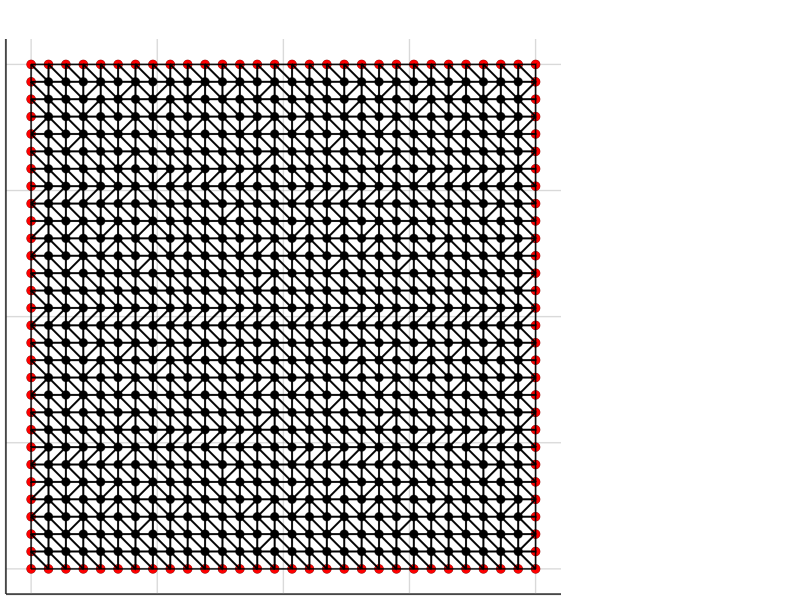

In [8]:
# Generar malla
P, S, B = MeshSquare(30)

# Plotear la malla
plotMesh(P, S, B)

In [9]:
# Supongamos que esta es mi solución (un vector de igual largo que P)
result = @. 8*P[:, 1]*(1-P[:, 1]) * P[:, 2] * (1-P[:, 2])
result2 = solve_poisson_dirichlet(x->1, P, S, B)

# Ploteamos la solución en la malla
plotField(P, S, result2)

GLMakie.Screen(...)